In [35]:
%run ../_preamble.ipynb
from _work.src.data import simple_dataloader as dataloader, small_dataloader
from _work.src.models import AutoEncoder
from _work.src.modules import train_model, test_model, plot_metrics, plot_parameters, plot_tensor, plot_grid, save_metrics, load_metrics
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch

In [ ]:
plot_tensor(dataloader.dataset.df);

In [ ]:
plot_tensor(small_dataloader.dataset.df);

In [45]:
for i in range(10):
    metrics = train_model(
        model := AutoEncoder(sizes=[dataloader.dataset.NUM_ATTRIBUTES, 2], batch_norm=True, dropout=0),
        optimizer := torch.optim.AdamW(model.parameters(), lr=1e-2),
        loss_fn := torch.nn.MSELoss(reduction="sum"),
        dataloader,
        epochs=500,
        noise_mean=0,
        noise_stdev=1,
    )

    save_metrics(metrics, f"test{i}")

In [46]:
metrics = [load_metrics(f"test{i}")[0] for i in range(10)]

In [47]:
x = pd.DataFrame()
for i, losses in enumerate([m.losses for m in metrics]):
    for type in ['train', 'test']:
        new = pd.DataFrame(data=losses[type], columns=['loss'])
        new['type'] = [type] * len(new)
        new['run'] = [i] * len(new)

        x = pd.concat([x, new])

x = x.reset_index(level=0).rename(columns={ 'index': 'epoch' })

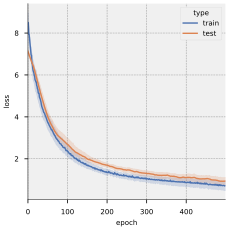

In [48]:
sns.lineplot(x="epoch", y="loss", hue='type', data=x);

In [ ]:
plot_grid(model, dataloader);

In [ ]:
from collections import defaultdict
from _work.src.modules.replay import iterate
from _work.src.modules.utils import get_closest_item


def transition_matrix(model, dataloader, mean=0, stdev=1, multiplier=1, runs=100, steps=10):
    transitions = defaultdict(lambda: defaultdict(lambda: 0))
    for item_a in dataloader.dataset.df.index:
        for item_b in dataloader.dataset.df.index:
            transitions[item_a][item_b] = 0

    for i, batch in enumerate(dataloader.dataset):
        origin = dataloader.dataset.df.index[i]
        item = batch["y"]

        states, _ = iterate(
            model,
            initial_state=item,
            mean=mean,
            stdev=stdev,
            multiplier=multiplier,
            runs=runs,
            steps=steps,
        )

        for final_state in states[:, 1:, :].reshape(-1, states.shape[-1]):
            closest_item, _ = get_closest_item(dataloader.dataset.df, final_state)
            transitions[origin][closest_item] += 1

    transitions = {k: dict(v) for k, v in transitions.items()}
    matrix = (
        pd.DataFrame(transitions)
        .transpose()
        .reindex(index=dataloader.dataset.df.index, columns=dataloader.dataset.df.index)
        .fillna(0)
        .astype(int)
    )
    matrix = matrix.divide(matrix.sum(axis=1), axis=0)
    return matrix

matrix = transition_matrix(model, dataloader)
plot_tensor(matrix);

In [ ]:
from sklearn.preprocessing import Normalizer
from scipy.spatial.distance import cdist

df = dataloader.dataset.df
dists = cdist(df, df, metric="correlation")
dists_normed = Normalizer().fit_transform(dists)
sims_normed = torch.tensor(1 - dists_normed)
plot_tensor(sims_normed);

In [ ]:
from scipy.optimize import minimize

def find_optimal_noise(model, dataloader):
    df = dataloader.dataset.df
    dists = cdist(df, df, metric="correlation")
    dists_normed = Normalizer().fit_transform(dists)
    sims_normed = torch.tensor(1 - dists_normed)

    def f(params):
        # mean, stdev, multiplier = params
        mean, stdev = params
        multiplier = 0.1
        matrix = transition_matrix(model, dataloader, runs=10, steps=10, mean=mean, stdev=stdev, multiplier=multiplier)
        matrix = torch.tensor(matrix.values)
        diff = matrix - sims_normed
        return torch.sum(diff * diff).item()
    
    # initial_guess = [0, 1, 0.1]
    initial_guess = [0, 1]
    result = minimize(f, initial_guess, method='powell')
    print(result)

find_optimal_noise(model, dataloader)

In [ ]:
matrix = transition_matrix(model, dataloader, runs=100, steps=10, mean=-2.33, stdev=2.2, multiplier=0.09)
plot_tensor(matrix);

In [ ]:
df = dataloader.dataset.df
dists = cdist(df, df, metric="correlation")
dists_normed = Normalizer().fit_transform(dists)
sims_normed = torch.tensor(1 - dists_normed)

means = np.linspace(-6, 3, num=100)
stdevs = np.linspace(0, 6, num=100)
x, y = np.meshgrid(means, stdevs)

def fun(mean, stdev):
    matrix = transition_matrix(model, dataloader, runs=10, steps=10, mean=mean, stdev=stdev, multiplier=0.1)
    matrix = torch.tensor(matrix.values)
    diff = matrix - sims_normed
    return torch.sum(diff * diff).item()

z = np.array([fun(a, b) for a, b in zip(x.ravel(), y.ravel())])
z = z.reshape(x.shape)

In [ ]:
from matplotlib.colors import LightSource
from matplotlib import cm

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
light = LightSource(90, 45)
illuminated_surf = light.shade(z, cmap=cm.viridis, vert_exag=0.1, blend_mode='soft')
# ax.plot_surface(x, y, z, alpha=0.9, cmap='viridis', antialiased=False, linewidth=0, shade=False);
ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=illuminated_surf, antialiased=False, linewidth=0.2, shade=False);